In this notebook, we investigate the impact of sample correlation on the error estimate of the free energy profile built in ThermoLIB. We also consider various alternative ways of constructing free energy profiles and estimating error bars and compare the results at the end. Herein, we will illustrate the routine ``decorrelate`` from the ThermoLIB tools allows for adequate error estimations.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
from thermolib.thermodynamics.fep import SimpleFreeEnergyProfile, plot_profiles
from thermolib.thermodynamics.histogram import Histogram1D
from thermolib.tools import read_wham_input, blav, decorrelate, corrtime_from_acf
from thermolib.thermodynamics.trajectory import ColVarReader

import numpy as np, matplotlib.pyplot as pp

from molmod.units import *

In [3]:
prefix = 'advanced_wham1D_error_'

# Impact MD correlation on WHAM reconstuction

In this section, we illustrate the impact of correlation between subsequent samples in the MD trajectories. To that end, we apply a regular WHAM procedure to all biased simulation data defined in data/wham_input.txt using all trajectory samples, as well as using only a sample every 10/100/1000 steps.

In [4]:
bins = np.arange(-1.6, 1.6, 0.02)
fn_meta = 'data/formic_acid_dimer_link/wham_input.txt'

In [5]:
colvar_reader_1 = ColVarReader([0], units=['au'])
temp, biasses, trajectories_1 = read_wham_input(
    fn_meta, colvar_reader_1, 'trajectories_correlated/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)
hist_1 = Histogram1D.from_wham(bins, trajectories_1, biasses, temp, error_estimate='mle_f', Nscf=10000)
fep_1 = SimpleFreeEnergyProfile.from_histogram(hist_1, temp=temp)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 01.425s
  bias poten. : 00h 00m 00.015s
  solve scf   : 00h 00m 00.454s
  error est.  : 00h 00m 00.522s
  TOTAL       : 00h 00m 02.418s
---------------------------------------------------------------------


In [6]:
colvar_reader_10 = ColVarReader([0], stride=10 ,units=['au'])
temp, biasses, trajectories_10 = read_wham_input(
    fn_meta, colvar_reader_10, 'trajectories_correlated/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)
hist_10 = Histogram1D.from_wham(bins, trajectories_10, biasses, temp, error_estimate='mle_f', Nscf=10000)
fep_10 = SimpleFreeEnergyProfile.from_histogram(hist_10, temp=temp)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.121s
  bias poten. : 00h 00m 00.014s
  solve scf   : 00h 00m 00.295s
  error est.  : 00h 00m 00.028s
  TOTAL       : 00h 00m 00.459s
---------------------------------------------------------------------


In [7]:
colvar_reader_100 = ColVarReader([0], stride=100 ,units=['au'])
temp, biasses, trajectories_100 = read_wham_input(
    fn_meta, colvar_reader_100, 'trajectories_correlated/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)
hist_100 = Histogram1D.from_wham(bins, trajectories_100, biasses, temp, error_estimate='mle_f', Nscf=10000)
fep_100 = SimpleFreeEnergyProfile.from_histogram(hist_100, temp=temp)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.014s
  bias poten. : 00h 00m 00.013s
  solve scf   : 00h 00m 00.710s
  error est.  : 00h 00m 00.045s
  TOTAL       : 00h 00m 00.783s
---------------------------------------------------------------------


In [8]:
colvar_reader_1000 = ColVarReader([0], stride=1000 ,units=['au'])
temp, biasses, trajectories_1000 = read_wham_input(
    fn_meta, colvar_reader_1000, 'trajectories_correlated/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)
hist_1000 = Histogram1D.from_wham(bins, trajectories_1000, biasses, temp, error_estimate='mle_f', Nscf=10000)
fep_1000 = SimpleFreeEnergyProfile.from_histogram(hist_1000, temp=temp)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.004s
  bias poten. : 00h 00m 00.014s
  solve scf   : 00h 00m 00.820s
  error est.  : 00h 00m 00.029s
  TOTAL       : 00h 00m 00.869s
---------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


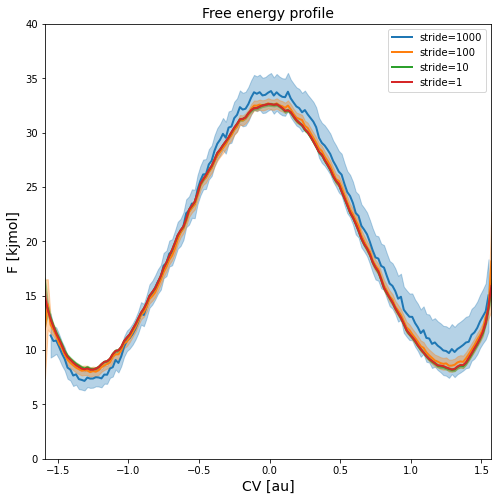

In [9]:
plot_profiles([fep_1000,fep_100,fep_10,fep_1], labels=['stride=1000', 'stride=100', 'stride=10', 'stride=1'], flims=[0,40])

The plot above indicates that the error becomes larger as the stride increases (which is logical as it gives WHAM a lot less data to work with). We also observe that the (mean) estimated free energy itself becomes more noisy as the stride increases, which is also due to lower number of samples.

# Estimating the autocorrelation time

The question now is which is the most reliable representation of the error. To that end, we estimate the correlation time from the autocorrelation function of the collective variable itself during the trajectories. We first illustrate this for a few individual trajectories:

The red dashed curve presents a fit of exp(-t/tau) to the red solid curve.
Fitted (integrated) correlation time: 2*tau-1 = 990.081 timesteps


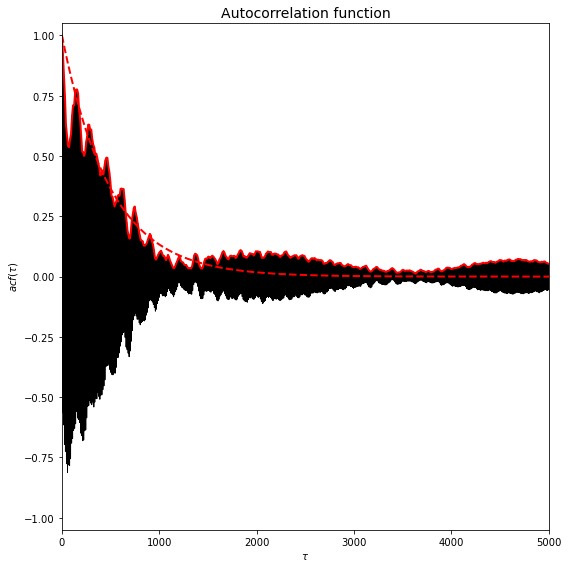

In [10]:
corrtime = corrtime_from_acf(trajectories_1[8], plot=True, xlims=[0,5000], ylims=[-1.05,1.05], fn_plot='advanced_error_acf.pdf')
print('The red dashed curve presents a fit of exp(-t/tau) to the red solid curve.')
print('Fitted (integrated) correlation time: 2*tau-1 = %.3f timesteps' %corrtime)

The above plot is an example of a typical situation in which the trajectory contains atomistic vibrations that happen on a very small time scale. These vibrations are responsible for the very high frequency oscillations you see in the plot above (resulting in the seemingly solid black region). If we want to fit a simple exponential function (to estimate the time decay constant which is the correlation time), we cannot fit directly to the curve itself as it fluctuates equally between above and below zero and hence any fit will give flat curve. Instead, we first filter out the very high frequency oscillations by computing the enveloppe of the curve. This is done by default in the corrtime_from_acf routine, but can be switched off by means of the argument `n_nested_envelopes=0`. In some cases, it is usefull to indeed switch this off. For example when you did a simulation in which you did not print out every time step, but only every so many time steps resulting in a time series that do not contain these high frequency oscillations any more. In other situations it might be the case the enveloppe still contains such oscillations that make fitting difficult, then you can compute the enveloppe of the enveloppe by setting `n_nested_envelopes=2`. Below, we show what happens if we put `n_nested_envelopes=2`.

/home/louis/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


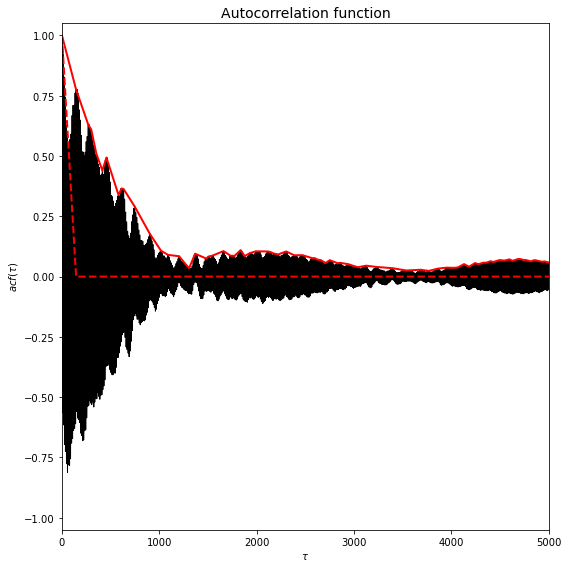

Fitted (integrated) correlation time: 2*tau-1 =  1.000 timesteps


In [11]:
ct = corrtime_from_acf(trajectories_1[8], plot=True, xlims=[0,5000], ylims=[-1.05,1.05], n_nested_envelopes=2)
print('Fitted (integrated) correlation time: 2*tau-1 =  %.3f timesteps' %ct)

You indeed see that the enveloppe contains even less oscillations. However, a new problem arises, a problem that also might have arissen from the start (e.g. again when the simulation only printed out every so many steps). This new issue is that the fit (dashed red line) is very bad. In fact, no fit was done at all as is hinted at by the fact that 2*tau-1=1 or hence tau=1. This is just the initial guess of tau (which is by default set to 1) is returned. Therefore, we need to adjust the initial gues of the correlation time tau to a better value, which we can do with the keyword `p0`. If we would make another bad guess, i.e. set the initial gues to 2, we will still be confronted with the same issue. Let us first illustrate that by indeed setting the initial guess to 2:

/home/louis/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


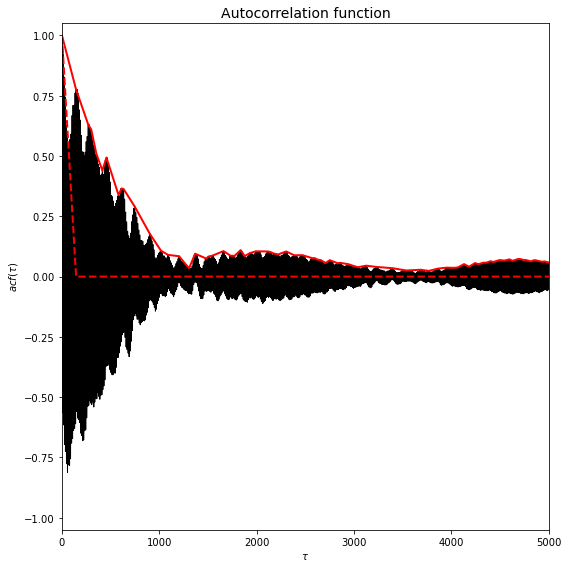

Fitted (integrated) correlation time: 2*tau-1 =  3.000 timesteps


In [12]:
ct = corrtime_from_acf(trajectories_1[8], plot=True, xlims=[0,5000], ylims=[-1.05,1.05], n_nested_envelopes=2, p0=[2])
print('Fitted (integrated) correlation time: 2*tau-1 =  %.3f timesteps' %ct)

We now again clearly see a bad fit, which is also again reflected by the fact that the result 2*tau-1=3 (hence tau=2) just returns the initial guess. In order to make a better initial gues, we can just look at the plot of the red solid line. We clearly see that the initial decay happens on a time scale of 1000 timesteps, so we could just use that as initial guess:

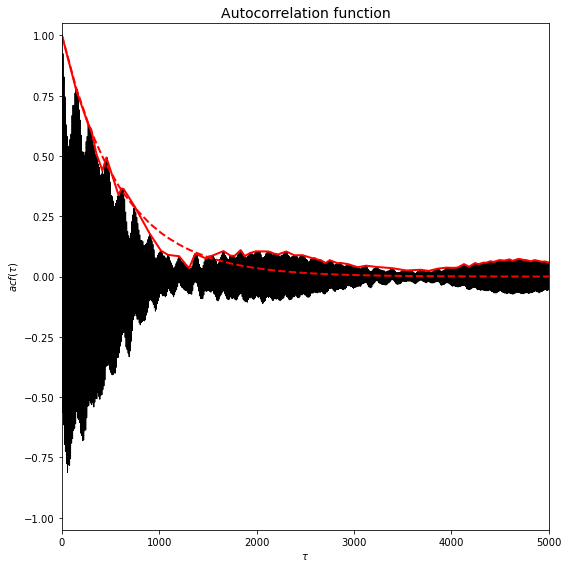

Fitted (integrated) correlation time: 2*tau-1 =  1190.743 timesteps


In [13]:
ct = corrtime_from_acf(trajectories_1[8], plot=True, xlims=[0,5000], ylims=[-1.05,1.05], n_nested_envelopes=2, p0=[1000])
print('Fitted (integrated) correlation time: 2*tau-1 =  %.3f timesteps' %ct)

Which now indeed represents a much better fit. The above discussion is included here to highlight what might happen when computing correlation times and how to try and adress those issues. In the present case, however, the default settings of n_nested_enveloppe=1 and p0=[1] is just fine and we therefore proceed with those default settings. Below we also make a plot of the autocorrelation function for a couple of other trajectories.

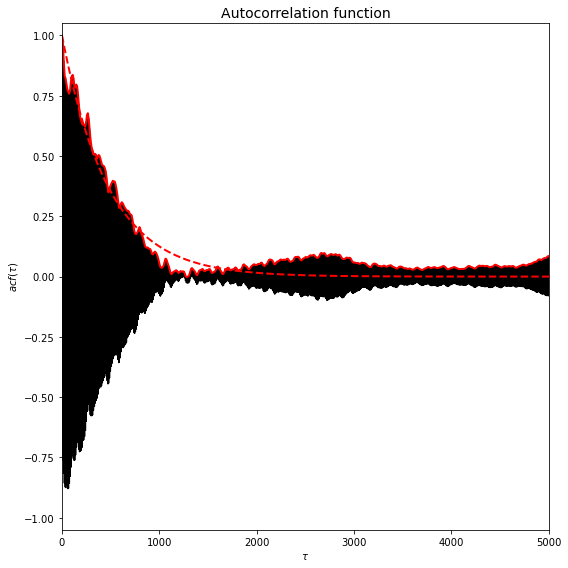

Correlation time = 961.006 timesteps


In [14]:
corrtime = corrtime_from_acf(trajectories_1[17], plot=True, xlims=[0,5000], ylims=[-1.05,1.05])
print('Correlation time = %.3f timesteps' %corrtime)

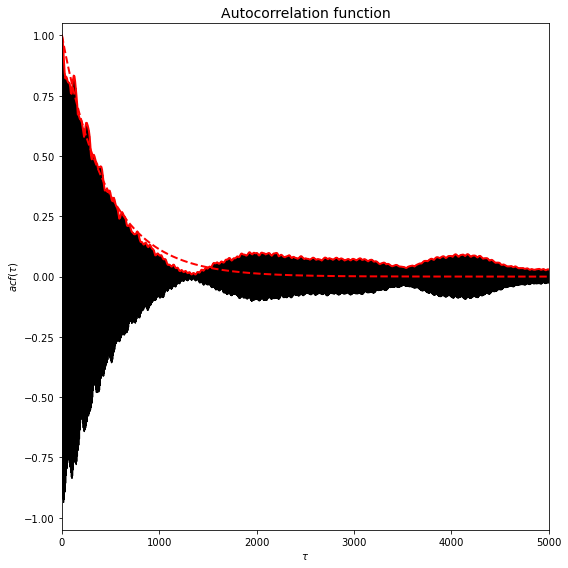

Correlation time = 916.428 timesteps


In [15]:
corrtime = corrtime_from_acf(trajectories_1[64], plot=True, xlims=[0,5000], ylims=[-1.05,1.05])
print('Correlation time = %.3f timesteps' %corrtime)

Let us now compute the correlation time for each trajectory and decorrelate the trajectories by averaging over blocks with length given by the correlation time. This is implemented in the `decorrelate` routine. In this routine, we can also adjust the parameters for the enveloppe and the initial conditions. The n_nested_enveloppe keyword is in this routine slighlty renamed to `acf_n_nested_envelopes` and the `p0` argument remains the same.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

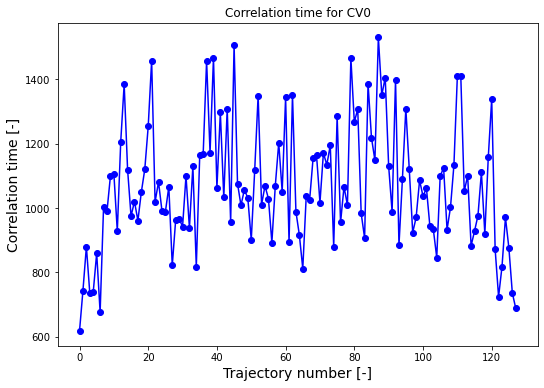

In [16]:
corrtimes = decorrelate(trajectories_1, plot=True, fn_plot='advanced_error_corrtimes.pdf')

The above routine returns the correlation times for each simulation (i.e. each umbrella). As the error estimation is based on the Fisher information matrix of the maximum likelihood estimator, we can reconstruct the free energy profile using all original samples, but now we also parse the correlation times to the `from_wham` routine to obtain a more reliable error estimation by accounting for the reduced information due to correlation (i.e. only N/corrtime independent samples) in the information matrix:

In [17]:
hist_decor = Histogram1D.from_wham(bins, trajectories_1, biasses, temp, error_estimate='mle_f', corrtimes=corrtimes, Nscf=10000)
fep_decor = SimpleFreeEnergyProfile.from_histogram(hist_decor, temp=temp)
#fep_decor.set_ref(ref='min')

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 01.275s
  bias poten. : 00h 00m 00.015s
  solve scf   : 00h 00m 00.363s
  error est.  : 00h 00m 00.030s
  TOTAL       : 00h 00m 01.684s
---------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

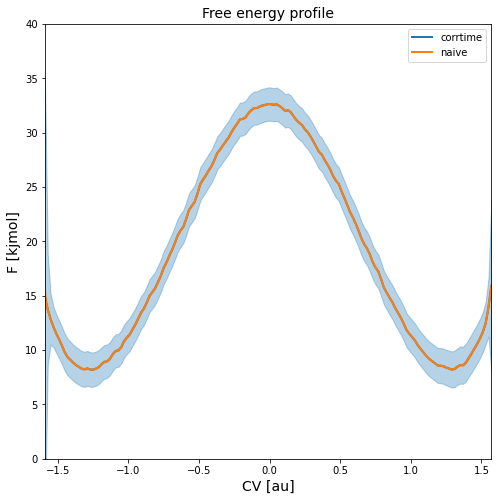

In [18]:
plot_profiles([fep_decor,fep_1], labels=['corrtime', 'naive'], flims=[0,40])

We indeed see that the error bar increases from almost zero (for the case of assuming all samples to be independent, i.e. correlation time equal to 0) to a value of around 1-2 kJ/mol based on the correlation time.

# Evaluating the error estimation

In order to test the above error estimation, we are now going to generate profiles from various sources of subsets of the original trajectories and investigate whether the WHAM profile generated by each subset indeed falls within the predicted error bar. The various methods for generating subsets of data are:

1) Delayed-strided profiles (with a stride of 1000 as that is approx the correlation time)
2) Blocked profiles
3) Bootstrapped profiles

## Delayed-strided WHAM profiles

In [19]:
starts = np.arange(0,1000,100)
feps = []
for start in starts:
    print("Constructing WHAM FEP for start=%i" %start)
    colvar_reader = ColVarReader([0], units=['au'], start=start, stride=1000)
    temp, biasses, trajectories = read_wham_input(
        fn_meta, colvar_reader, 'trajectories_correlated/COLVAR_%s.dat', 
        bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
    )    
    hist = Histogram1D.from_wham(bins, trajectories, biasses, temp, Nscf=10000)
    fep = SimpleFreeEnergyProfile.from_histogram(hist, temp)
    #fep.set_ref(ref='min')
    feps.append(fep)

Constructing WHAM FEP for start=0
SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.005s
  bias poten. : 00h 00m 00.013s
  solve scf   : 00h 00m 00.879s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.898s
---------------------------------------------------------------------
Constructing WHAM FEP for start=100
SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.004s
  bias poten. : 00h 00m 00.013s
  solve scf   : 00h 00m 00.784s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.802s
---------------------------------------------------------------------
Constructing WHAM FEP for start=200
SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.004s
  bias

<Figure size 432x288 with 0 Axes>

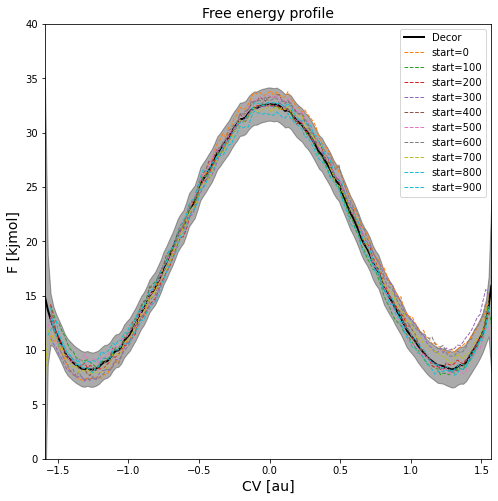

In [23]:
fep_delstr = SimpleFreeEnergyProfile.from_average(feps, error_estimate='std')
plot_profiles([fep_decor]+feps, labels=['Decor']+['start=%i' %start for start in starts], flims=[0,40],
               colors    =['k']+[None,]*len(starts),
               linewidths=[2  ]+[1   ,]*len(starts),
               linestyles=['-']+['--',]*len(starts))

All profiles indeed fall within the predicted 2-sigma error bar.

## Blocked WHAM profiles

We now devide the original data in 10 subsequent blocks and compute the WHAM FEP for each block

In [24]:
nblocks = 10
blocksize = int(min([len(traj) for traj in trajectories_1])/nblocks)
feps2 = []
labels2 = []
for iblock in range(nblocks):
    start, end = iblock*blocksize, (iblock+1)*blocksize
    print("Constructing histogram for block [%i,%i]" %(start,end))
    colvar_reader = ColVarReader([0], units=['au'], start=start, end=end, stride=1)
    temp, biasses, trajectories = read_wham_input(
        fn_meta, colvar_reader, 'trajectories_correlated/COLVAR_%s.dat', 
        bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
    )
    hist = Histogram1D.from_wham(bins, trajectories, biasses, temp)
    fep = SimpleFreeEnergyProfile.from_histogram(hist, temp)
    #fep.set_ref(ref='min')
    feps2.append(fep)
    labels2.append("Block[%i,%i]"%(start,end))

Constructing histogram for block [0,20000]
SCF did not converge!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.117s
  bias poten. : 00h 00m 00.013s
  solve scf   : 00h 00m 00.110s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.240s
---------------------------------------------------------------------
Constructing histogram for block [20000,40000]
SCF did not converge!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.122s
  bias poten. : 00h 00m 00.015s
  solve scf   : 00h 00m 00.116s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.254s
---------------------------------------------------------------------
Constructing histogram for block [40000,60000]
SCF did not converge!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00

<Figure size 432x288 with 0 Axes>

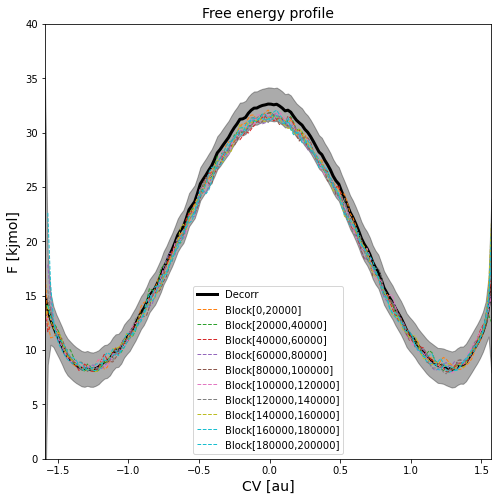

In [25]:
fep_block = SimpleFreeEnergyProfile.from_average(feps2, error_estimate='std')
plot_profiles([fep_decor]+feps2, labels=['Decorr']+labels2, flims=[0,40], 
                colors    =['k']+[None,]*nblocks, 
                linestyles=['-']+['--',]*nblocks, 
                linewidths=[3  ]+[1   ,]*nblocks)

Again all profiles are within the predicted 2-sigma error bar.

## Bootstrapped WHAM profiles

Finally, we again reconstruct various FEPS, but know using bootstrapping applied to each of the original biased simulations. Again, we consider 10 trajectories.

In [26]:
Nboot = 10
feps3 = []
for iboot in range(Nboot):
    new_trajectories = []
    for traj in trajectories_1:
        Nsteps = len(traj)
        indices = np.random.randint(0, high=Nsteps, size=int(Nsteps/Nboot))
        new_trajectories.append(traj[indices]) 
    hist = Histogram1D.from_wham(bins, new_trajectories, biasses, temp, Nscf=10000)
    fep = SimpleFreeEnergyProfile.from_histogram(hist, temp)
    #fep.set_ref(ref='min')
    feps3.append(fep)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.126s
  bias poten. : 00h 00m 00.021s
  solve scf   : 00h 00m 00.539s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.687s
---------------------------------------------------------------------
SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.120s
  bias poten. : 00h 00m 00.012s
  solve scf   : 00h 00m 00.351s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.485s
---------------------------------------------------------------------
SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.130s
  bias poten. : 00h 00m 00.013s
  solve scf   : 00h 00m 00.521s
  error est.  : 00h 00m 00.000s
  TOTAL       : 

<Figure size 432x288 with 0 Axes>

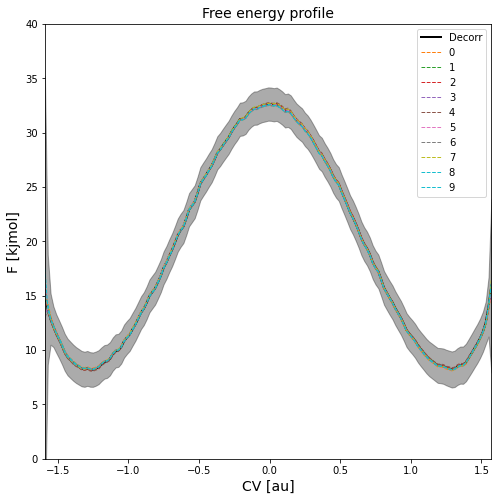

In [27]:
fep_boot = SimpleFreeEnergyProfile.from_average(feps3, error_estimate='std')
plot_profiles([fep_decor]+feps3, labels=['Decorr']+['%i' %i for i in np.arange(0,10,1)], flims=[0,40],
               colors    =['k']+[None,]*10,
               linewidths=[2  ]+[1   ,]*10,
               linestyles=['-']+['--',]*10)

# Covariance between different points on FEP

It is important to realize that the free energy at $q_1$ is not independent from the free energy at $q_2$. This is not only the case for close neighbors (large positive correlation), but in the present case of a profile with two equistable minima, also between points from these equistable minima (i.e. reactant and product state). The main reason for this the fact that the free energy is derived from a normalized probability and this normalization introduces a strong negative correlation between these two equistable minima, because decreased free energy (i.e. increased probability) for reactant implies increased free energy (i.e. decreased probality) for product. 

To illustrate the importance of this, we first plot samples of the full free energy profile according to 'uncorrelated' error bars (using `error_estimate=mle_f`) and show the difference with the scenario where we redo the error estimation with explicit covariance using `error_estimate=mle_f_cov`.

Considering first the free energy profile without covariance, we can plot samples using the plot routine as follows:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


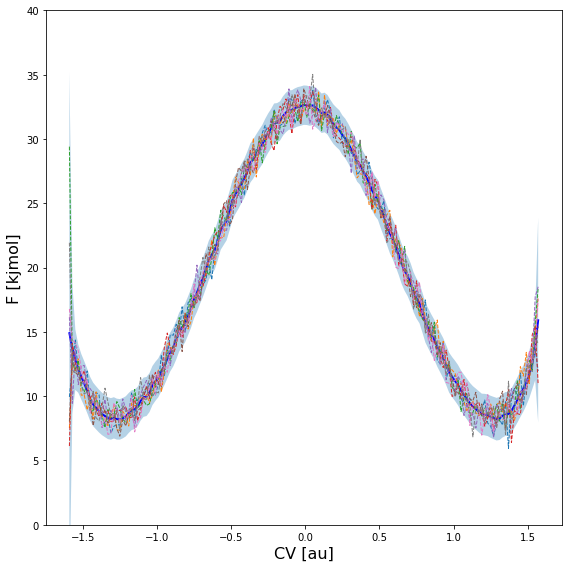

In [28]:
fep_decor.plot(
    obss      = ['mean']+['sample',]*8,
    linestyles=    ['-']+    ['--',]*8,
    linewidths=      [2]+       [1,]*8,
    colors    =    ['b']+    [None,]*8,
    flims=[0,40]
)

As we can see, the error just corresponds to normally random fluctuations on all points individually without any correlation between fluctuations.

We now reconstruct the error on the fep by explicitly taking the covariance into account.

In [29]:
hist_cov = Histogram1D.from_wham(bins, trajectories_1, biasses, temp, error_estimate='mle_f_cov', corrtimes=corrtimes, Nscf=10000)
fep_cov = SimpleFreeEnergyProfile.from_histogram(hist_cov, temp, cv_output_unit='au', cv_label='CV', f_output_unit='kjmol')
fep_cov.process_states(lims=[-1.5,-0.2,0.2,1.5])

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 01.241s
  bias poten. : 00h 00m 00.020s
  solve scf   : 00h 00m 00.354s
  error est.  : 00h 00m 00.029s
  TOTAL       : 00h 00m 01.645s
---------------------------------------------------------------------


As can be seen in the free energy profile below, the 2-sigma error bar on the entire profile is identical with or without accounting for covariance:

<Figure size 432x288 with 0 Axes>

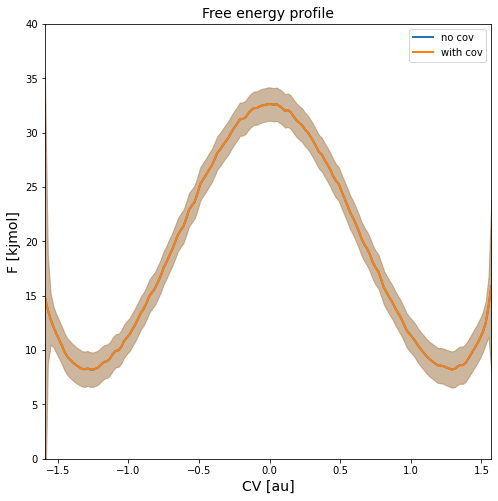

In [30]:
plot_profiles([fep_decor,fep_cov], labels=['no cov', 'with cov'], flims=[0,40])

However, the coviarance is clearly non neglible as seen in the matrix plot below of the correlation matrix between the various points on the fep. This correlation ranges from 1 (perfect correlation), to 0 (completely uncorrelated) and -1 (perfect anticorrelation).

<Figure size 432x288 with 0 Axes>

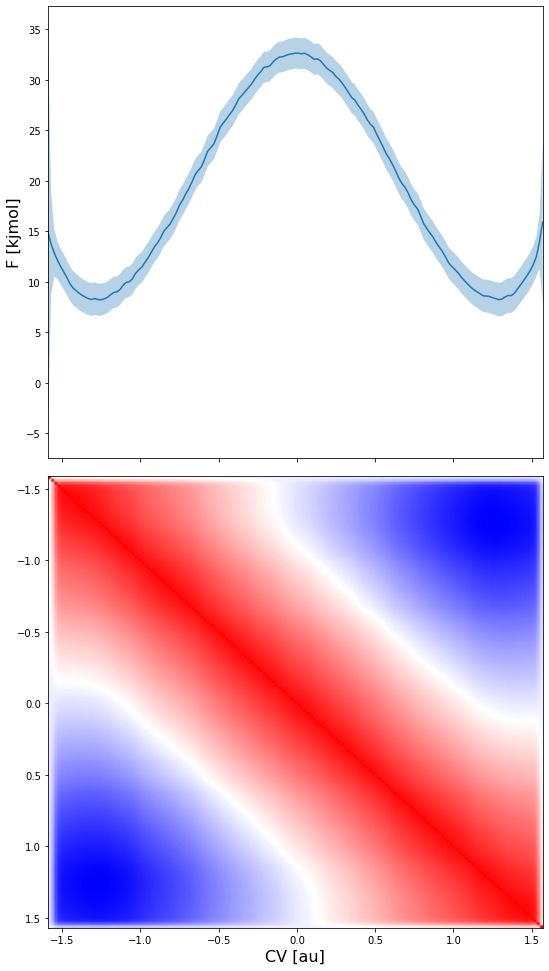

In [31]:
fep_cov.plot_corr_matrix(fn='basic_plotcorrmatrix.pdf')

Therefore, the error model in fep_cov generates much more reliable 'samples' of the full free energy profile by taking into account the full covariance matrix. This can again be plotted using the `fep_cov.plot_samples` routine:

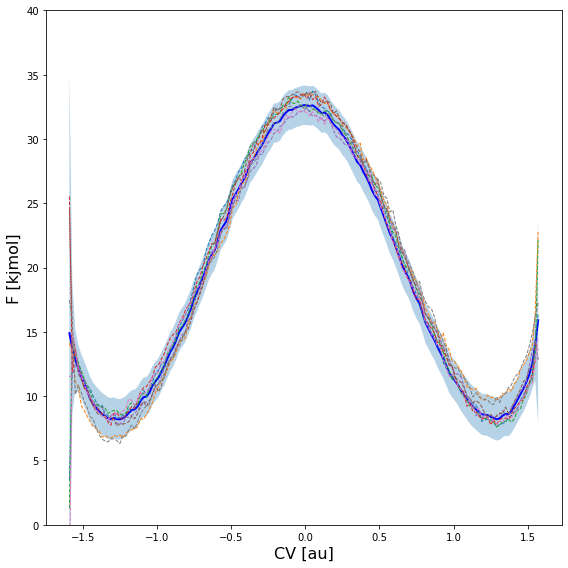

In [32]:
fep_cov.plot(
    obss      = ['mean']+['sample',]*8,
    linestyles=    ['-']+    ['--',]*8,
    linewidths=      [2]+       [1,]*8,
    colors    =    ['b']+    [None,]*8,
    flims=[0,40]
)

This figure clearly illustrates that higher free energy for reactant state also implies lower free energy for the product state and vice versa! Such correlated estimates of samples of the full free energy profile allows to do proper error propagation, i.e. to compute the free energy of integrated macrostates. To illustrate that, we compute propagate the error on the profile to that on the microstate/macrostate free energy derived from the profile for both the fep without covariance (i.e. fep_decor) and that with covariance estimate (i.e. fep_cov):

In [33]:
fep_decor.process_states(lims=[-1.5,-0.5,0.5,1.5], verbose=True)

MICROSTATE ts:
--------------
  index =  None
  F     = 33.699 +- 0.785 kjmol
  CV    = -0.006 +- 0.161 au

MICROSTATE r:
--------------
  index =  None
  F     = 7.080 +- 1.020 kjmol
  CV    = -1.272 +- 0.102 au

MICROSTATE p:
--------------
  index =  None
  F     = 7.131 +- 0.776 kjmol
  CV    = 1.270 +- 0.129 au

MACROSTATE R:
--------------
  F       = 10.341 +- 0.391 kjmol
  CV Mean = -1.238 +- 0.016 au
  CV StD  = 0.146 +- 0.009 au

MACROSTATE P:
--------------
  F       = 10.398 +- 0.385 kjmol
  CV Mean = 1.233 +- 0.013 au
  CV StD  = 0.145 +- 0.009 au



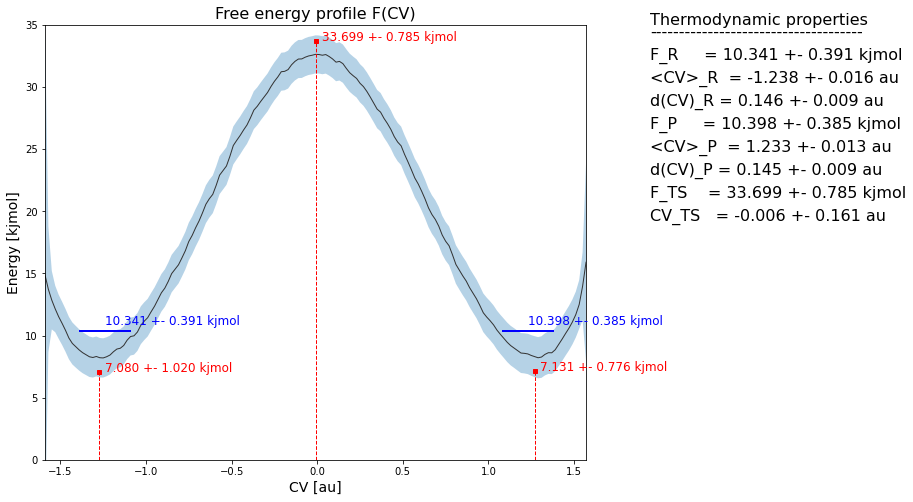

In [34]:
fep_decor.plot(flims=[0,35])

Here, we clearly see that estimate of the red microstate dots representing local minima (reactant ant product) and maxima (transition state) are located on the lower/upper edge of the error bar respectively. That is because in the random samples of the full fep, the lack of correlation between neighboring points (which results in uncorrelated fluctuation on the free energy of each point) ensures that there will always be a point close to the lower/upper error bar boundary. Furthermore, we also see a much lower error on the blue macrostates representing the integral over reactant (left of ts) and product (right of ts) microstates. This is because the random fluctuation resulting the uncorrelated error bar is moslty filtered out by the integral.

This clearly indicates the failure of uncorrelated error bars for propagation towards derived properties. Instead, we need to do such error propagation using correlated error bars coming from accounting for the full covariance matrix.

In [35]:
fep_cov.process_states(lims=[-1.5,-0.5,0.5,1.5], verbose=True)

MICROSTATE ts:
--------------
  index =  None
  F     = 32.773 +- 1.396 kjmol
  CV    = -0.012 +- 0.108 au

MICROSTATE r:
--------------
  index =  None
  F     = 8.037 +- 1.307 kjmol
  CV    = -1.276 +- 0.097 au

MICROSTATE p:
--------------
  index =  None
  F     = 8.028 +- 1.457 kjmol
  CV    = 1.279 +- 0.085 au

MACROSTATE R:
--------------
  F       = 10.710 +- 1.661 kjmol
  CV Mean = -1.235 +- 0.027 au
  CV StD  = 0.147 +- 0.011 au

MACROSTATE P:
--------------
  F       = 10.506 +- 1.607 kjmol
  CV Mean = 1.235 +- 0.027 au
  CV StD  = 0.145 +- 0.011 au



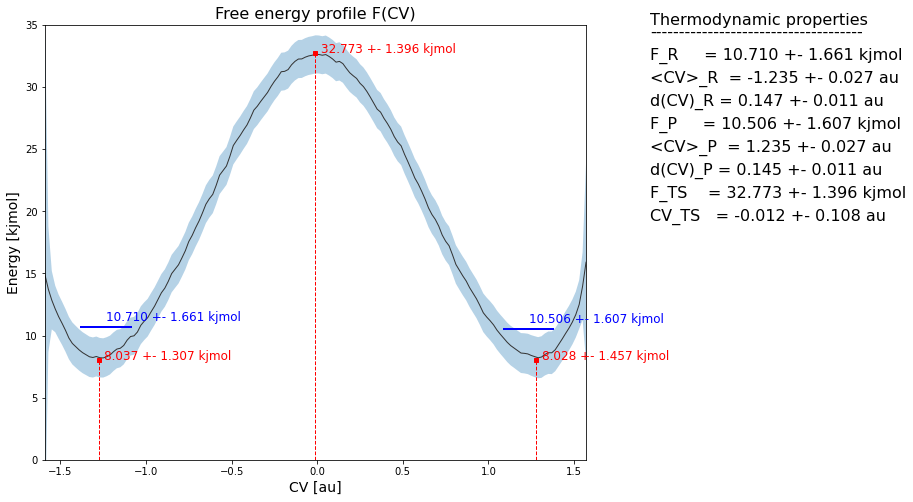

In [36]:
fep_cov.plot(flims=[0,35])